In [1]:
import logging

logging.basicConfig(level=logging.INFO)

from ray.tune import Trainable
from ray.tune.utils import wait_for_gpu
import torch
import sys

import json

# print(f"sys path in experiment: {sys.path}")
from pathlib import Path

from shrp.datasets.dataset_tokens import DatasetTokens

from shrp.git_re_basin.git_re_basin import (
    PermutationSpec,
    zoo_cnn_permutation_spec,
    resnet18_permutation_spec,
    weight_matching,
    apply_permutation,
)

# import model_definitions
from shrp.models.def_AE_module import AEModule

from torch.utils.data import DataLoader

from shrp.models.def_downstream_module import DownstreamTaskLearner

from ray.air.integrations.wandb import setup_wandb

import logging

from shrp.datasets.augmentations import (
    AugmentationPipeline,
    TwoViewSplit,
    WindowCutter,
    MultiWindowCutter,
    ErasingAugmentation,
    NoiseAugmentation,
)


INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp6zlj_1dy
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp6zlj_1dy/_remote_module_non_scriptable.py


In [2]:
zoo_path = [
    Path(
        "/netscratch2/kschuerholt/code/versai/model_zoos/zoos/CIFAR10/resnet19/kaiming_uniform/tune_zoo_cifar10_resnet18_kaiming_uniform"
    ).absolute()
]
epoch_list = [1, 3, 5, 10, 15, 20, 25]
permutation_spec = resnet18_permutation_spec()
map_to_canonical = True
# map_to_canonical = False
standardize = True
ds_split = [0.7, 0.15, 0.15]
max_samples = 200
weight_threshold = 2500
num_threads = 30
shuffle_path = True
windowsize = 160
supersample = "auto"
# supersample = 2
# supersample = 1
precision = "32"
# precision = "b16"
ignore_bn = True
tokensize = 576
# test: tokensize = [0,576/2, 576]
# test: standardize (visualize results)
# test ignore_bn = [true, false]

split = "val"

result_key_list = ["test_acc", "training_iteration", "ggap"]
config_key_list = [
    # "model::nlin",
    # "model::init_type",
    # "model::dropout",
    # "optim::lr",
    # "optim::wd",
]
property_keys = {
    "result_keys": result_key_list,
    "config_keys": config_key_list,
}


dataset = DatasetTokens(
        root=zoo_path,
        epoch_lst=epoch_list,
        permutation_spec=permutation_spec,
        map_to_canonical=map_to_canonical,
        standardize=standardize,
        tokensize= tokensize, 
        train_val_test=split,  # determines which dataset split to use
        ds_split=ds_split,  #
        max_samples=max_samples,
        weight_threshold=weight_threshold,
        precision=precision,
        filter_function=None,  # gets sample path as argument and returns True if model needs to be filtered out
        property_keys=property_keys,
        num_threads=12,
        shuffle_path=True,
        verbosity=3,
        getitem="tokens+props",
        ignore_bn = ignore_bn,
        supersample = 1,
)



INFO:root:reference checkpoint found at /netscratch2/kschuerholt/code/versai/model_zoos/zoos/CIFAR10/resnet19/kaiming_uniform/tune_zoo_cifar10_resnet18_kaiming_uniform/NN_tune_trainable_0ecbc_00155_155_seed=156_2022-08-05_04-56-00
2023-05-10 04:22:30,464	INFO worker.py:1553 -- Started a local Ray instance.
INFO:root:loading checkpoints from [PosixPath('/netscratch2/kschuerholt/code/versai/model_zoos/zoos/CIFAR10/resnet19/kaiming_uniform/tune_zoo_cifar10_resnet18_kaiming_uniform')]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:23<00:00,  8.92it/s]
INFO:root:Data loaded. found 30 usable samples out of potential 210 samples.
INFO:root:Load properties for samples from paths.
INFO:root:### load data for dict_keys(['test_acc', 'training_iteration', 'ggap'])
30it [00:01, 21.87it/s]
INFO:roo

preparing computing canon form...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.63it/s]
INFO:root:init dataset length
INFO:root:tokenize data
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:58<00:00,  5.95s/it]
INFO:root:standardize data
INFO:root:Get layer mapping
INFO:root:Get layer-wise mean and std
/usr/local/lib/python3.8/dist-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information

In [3]:
dataset.__getitem__(0)

(tensor([[ 1.2280e+00, -5.6735e-02,  3.6249e-01,  ...,  6.7163e-03,
           6.7163e-03,  6.7163e-03],
         [-1.3636e+00,  1.5333e+00, -6.1721e-01,  ...,  6.7163e-03,
           6.7163e-03,  6.7163e-03],
         [-1.5147e-01, -1.1384e-01,  1.3411e+00,  ...,  6.7163e-03,
           6.7163e-03,  6.7163e-03],
         ...,
         [ 1.0068e+00, -1.4598e+00,  1.7047e+00,  ..., -4.9240e-04,
          -4.9240e-04, -4.9240e-04],
         [ 2.8327e-01, -1.0899e+00, -1.8235e+00,  ..., -4.9240e-04,
          -4.9240e-04, -4.9240e-04],
         [-6.2464e-01,  1.5004e+00, -5.9740e-01,  ..., -4.9240e-04,
          -4.9240e-04, -4.9240e-04]]),
 tensor([[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, F

In [4]:
dataset.__getitem__(0)[0].shape

torch.Size([20042, 576])

# visualize token

In [5]:
mask = dataset.mask

In [6]:
m = mask.sum(dim=1)
m.shape

torch.Size([20042])

In [7]:
pos = dataset.positions
p = pos[:,1]
p.shape

torch.Size([20042])

In [8]:
idx=0
x_list = []
for key in dataset.reference_checkpoint.keys():
    if "weight" in key:
        if ignore_bn and "bn" in key:
            continue
        mod = dataset.reference_checkpoint[key]
        mod = mod.view(mod.shape[0],-1)
#         print(idx, key,mod.shape)
        idx+=1
        x_list.append(key)

In [9]:
for idx in range(len(x_list)):
    x_list[idx] = f"{idx} -"+x_list[idx].replace(".weight","")

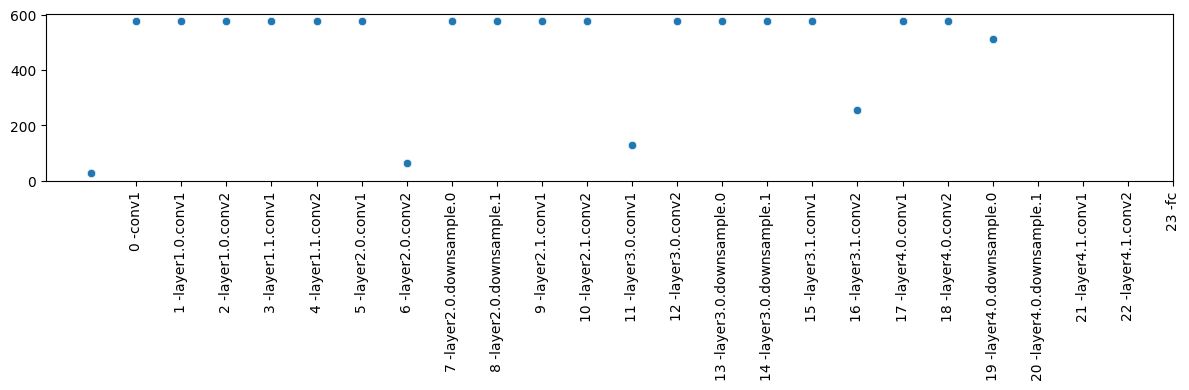

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,4))
sns.scatterplot(x=p,y=m,ax=ax)

plt.xticks(list(range(1,len(x_list)+1)), x_list, rotation=90)

fig.tight_layout()


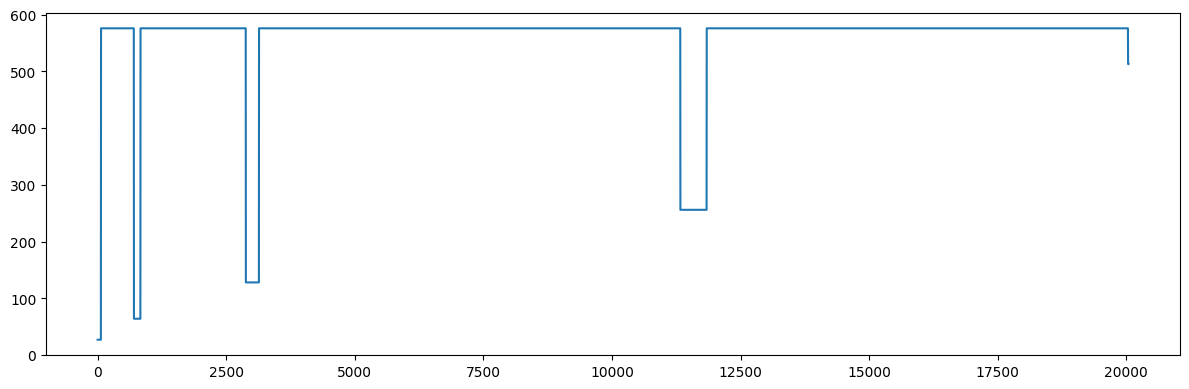

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

p = pos[:,0]
fig, ax = plt.subplots(figsize=(12,4))
# sns.scatterplot(x=p,y=m,ax=ax)
sns.lineplot(x=p,y=m,ax=ax)

# plt.xticks(list(range(0,41)), x_list, rotation=90)

fig.tight_layout()


In [12]:
idx=0
for key in dataset.reference_checkpoint.keys():
    if "weight" in key:
        if ignore_bn and "bn" in key:
            continue
        mod = dataset.reference_checkpoint[key]
        mod = mod.view(mod.shape[0],-1)
        print(idx, key,mod.shape)
        idx+=1

0 conv1.weight torch.Size([64, 27])
1 layer1.0.conv1.weight torch.Size([64, 576])
2 layer1.0.conv2.weight torch.Size([64, 576])
3 layer1.1.conv1.weight torch.Size([64, 576])
4 layer1.1.conv2.weight torch.Size([64, 576])
5 layer2.0.conv1.weight torch.Size([128, 576])
6 layer2.0.conv2.weight torch.Size([128, 1152])
7 layer2.0.downsample.0.weight torch.Size([128, 64])
8 layer2.0.downsample.1.weight torch.Size([128, 1])
9 layer2.1.conv1.weight torch.Size([128, 1152])
10 layer2.1.conv2.weight torch.Size([128, 1152])
11 layer3.0.conv1.weight torch.Size([256, 1152])
12 layer3.0.conv2.weight torch.Size([256, 2304])
13 layer3.0.downsample.0.weight torch.Size([256, 128])
14 layer3.0.downsample.1.weight torch.Size([256, 1])
15 layer3.1.conv1.weight torch.Size([256, 2304])
16 layer3.1.conv2.weight torch.Size([256, 2304])
17 layer4.0.conv1.weight torch.Size([512, 2304])
18 layer4.0.conv2.weight torch.Size([512, 4608])
19 layer4.0.downsample.0.weight torch.Size([512, 256])
20 layer4.0.downsample.1.w

In [13]:
# get layer_1 weights
weights, _ = dataset.__get_weights__()

In [14]:
weights.shape

torch.Size([150, 20042, 576])

In [15]:
layers = torch.unique(pos[:,1])
layers=[ldx.item() for ldx in layers]

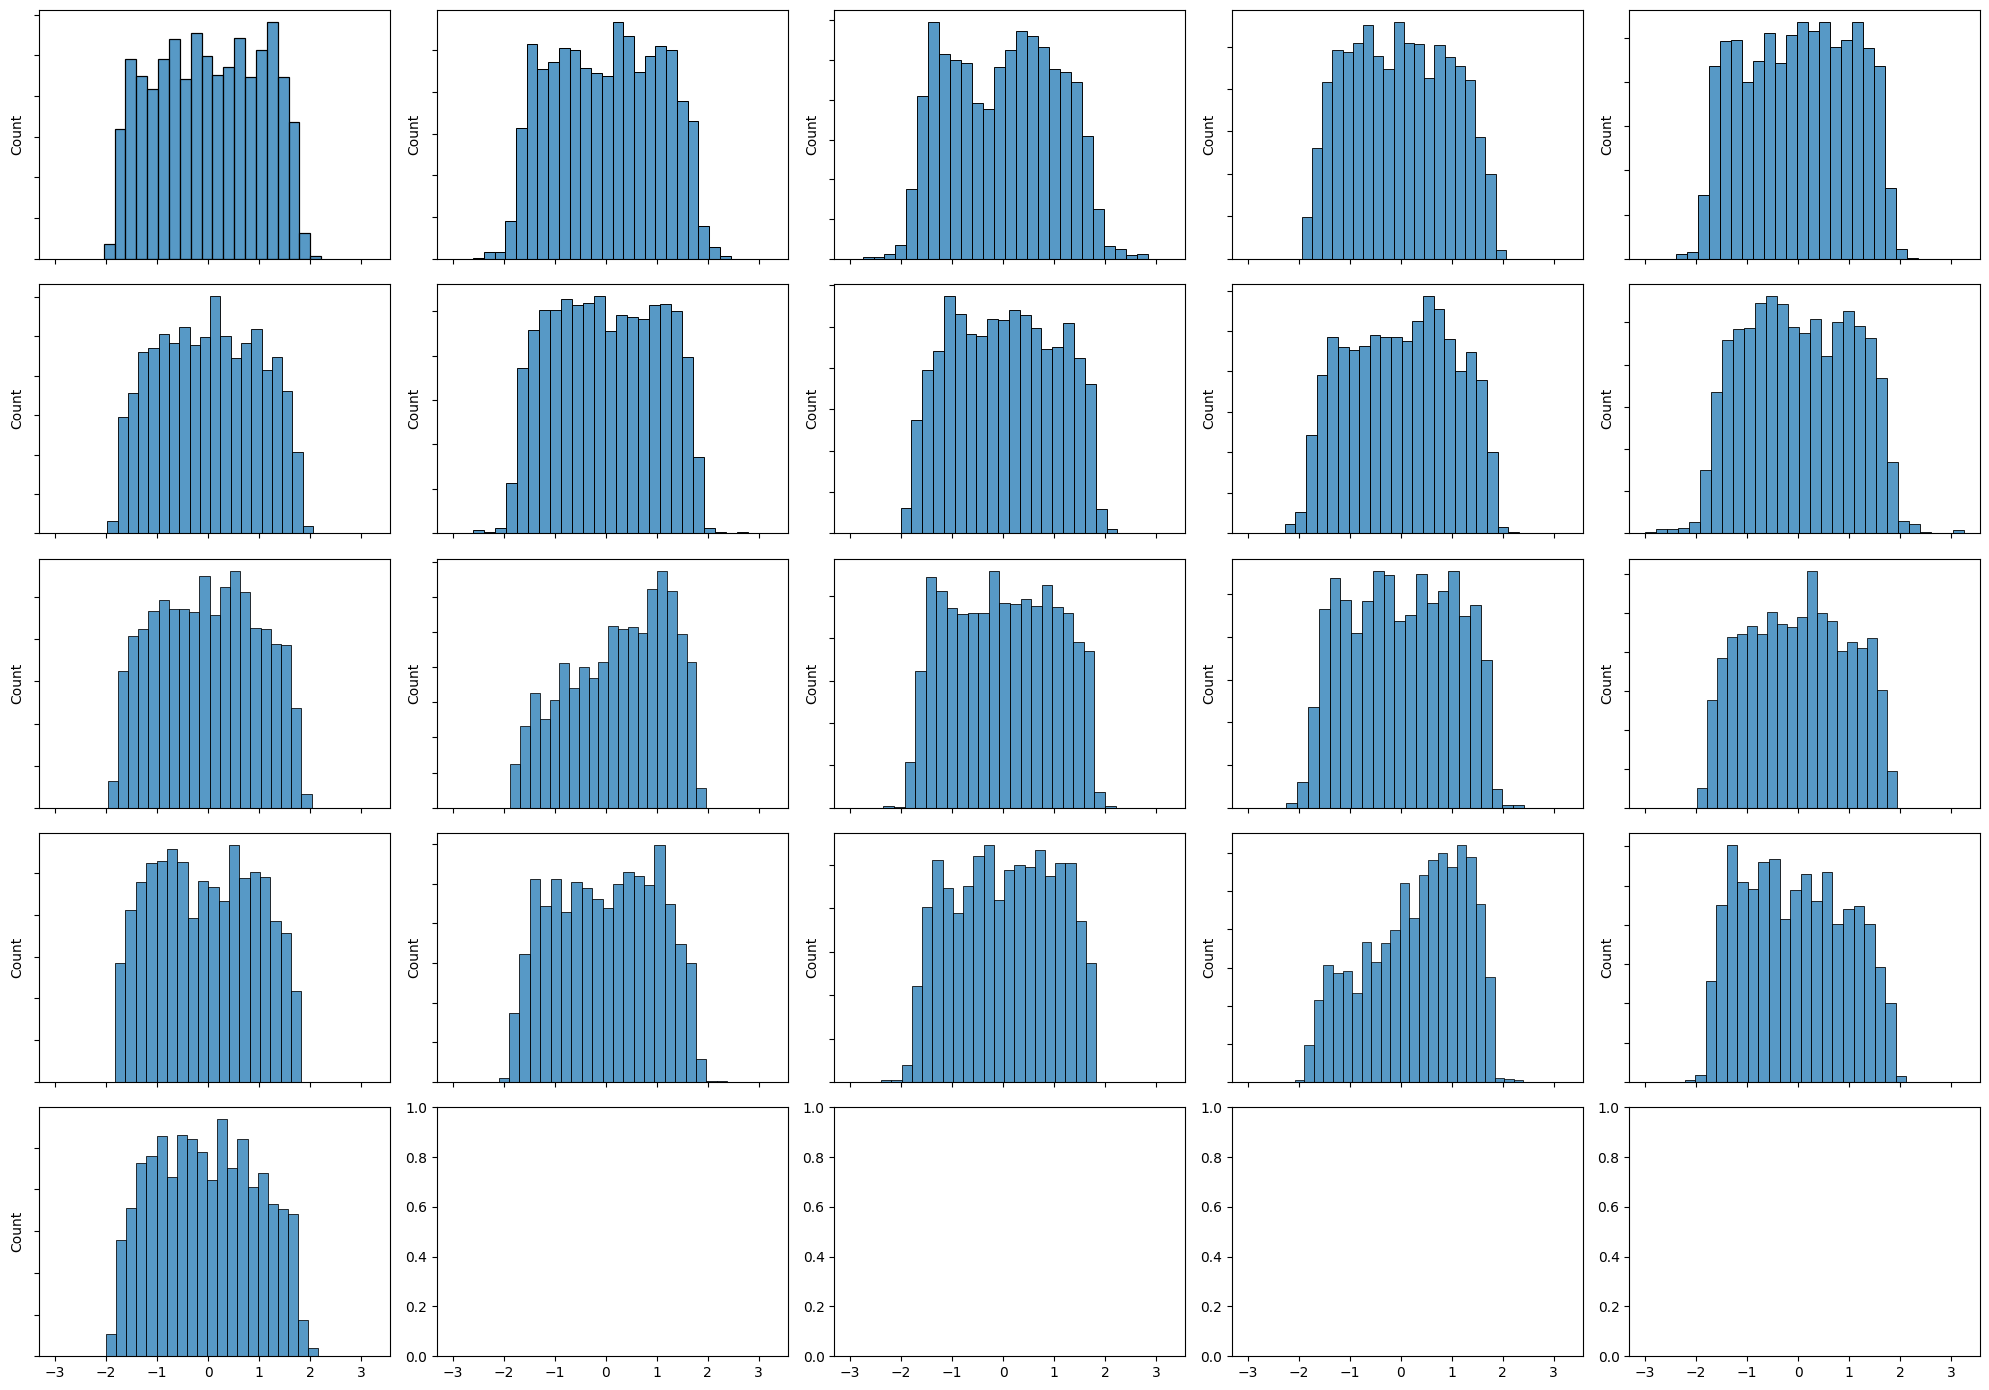

In [16]:
import  math
figs_per_row = 5

fig, ax = plt.subplots(nrows=math.ceil(len(layers)/figs_per_row),ncols=figs_per_row,sharex=True, figsize=(20,14))

for idx,ldx in enumerate(layers):
    
    cdx = idx%figs_per_row
    rdx = idx//figs_per_row
    adx = ax[rdx,cdx]
    
#     if rdx>1:
#         break
    
    idx_l = torch.where(p==ldx)
    # print(len(idx_l[0]))
    w_l = torch.index_select(input=weights,index=idx_l[0],dim=1)
    w_l.shape
    # get mask
    m_l = torch.index_select(input=mask,index=idx_l[0],dim=0)
    m_l = torch.where(m_l[0,:]==1)

    # apply mask
    w_l = torch.index_select(input=w_l,index=m_l[0],dim=2)

    sns.histplot(w_l.flatten(),ax=adx)
    adx.set_yticklabels([])

    

fig.tight_layout()